## Context
we've explored maximum likelihood methods before of the sort:
$$\hat{a}=[A^TN^{-1}A]^{-1}A^TN^{-1}d
$$
and have found that we don't get fantastic reconstruction unless we use
 - loads of antennas
 - focus only on low-l modes
 - use some kind of missing-modes modelling
 (details are in Imperfect observation strategy in Notion).

The fact that we couldn't reconstruct the monopole well using two antennas with this method made me give up, favouring a method that explicitly uses frequency structure information. Now I'm wondering whether using a large array of antennas we can't get good enough reconstructions of the $l=0$ mode so that a power law + gaussian trough can't be fit over this. It doesn't have to be realistic or good - we could in fact definitely pull a bit of a paper 1 trick and say "lol it's bad but oh well!".


In [2]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from numpy.linalg import svd
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
from src.blockmat import BlockMatrix, BlockVector

RS = SH.RealSphericalHarmonics()

## Single-frequency reconstruction (for posterity).

In [3]:
# model and observation params
lmax=32
nside=32
npix=hp.nside2npix(nside)
nu=60
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)

npix = hp.nside2npix(nside)
# Generate the ylm matrix for later.
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Generate foreground map.
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nu, lmax=lmax, nside=nside, use_mat_Y=True)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


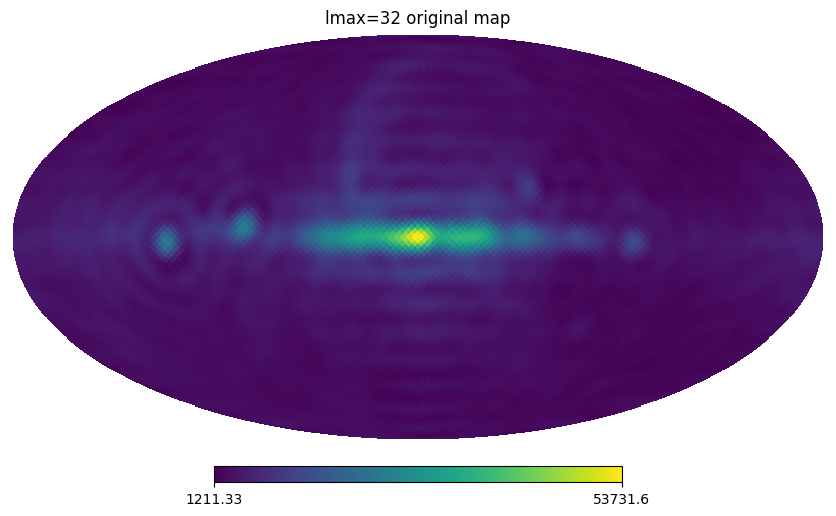

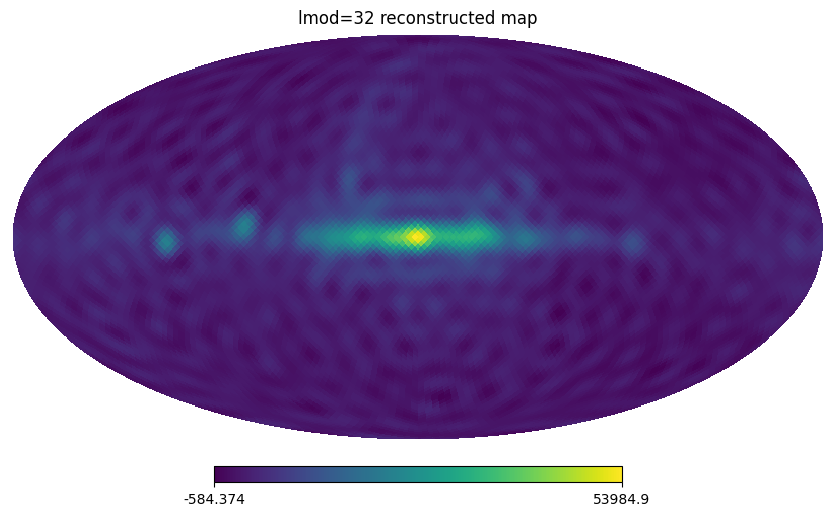

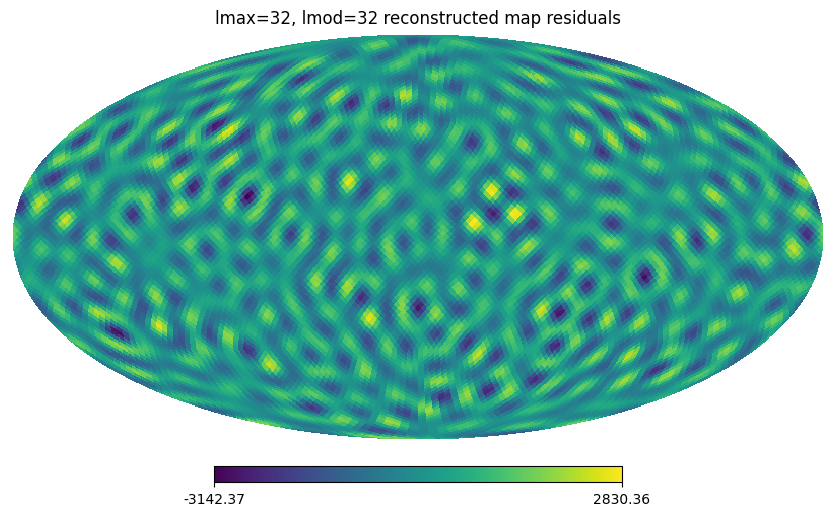

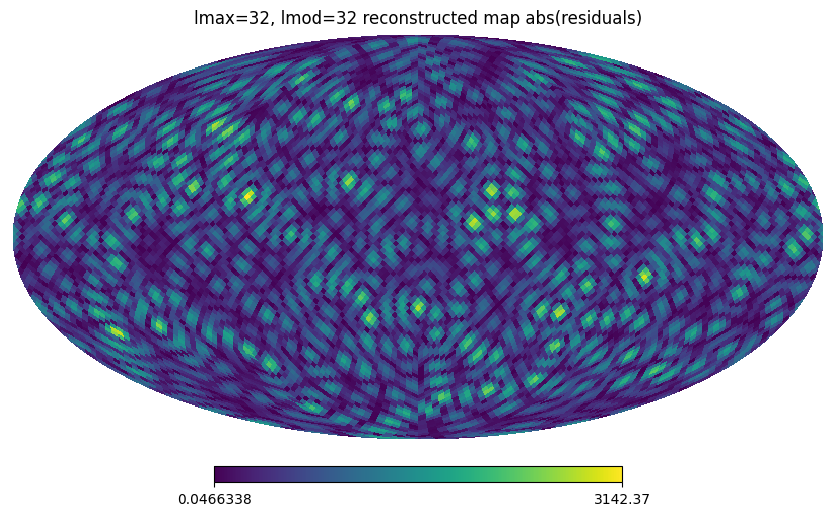

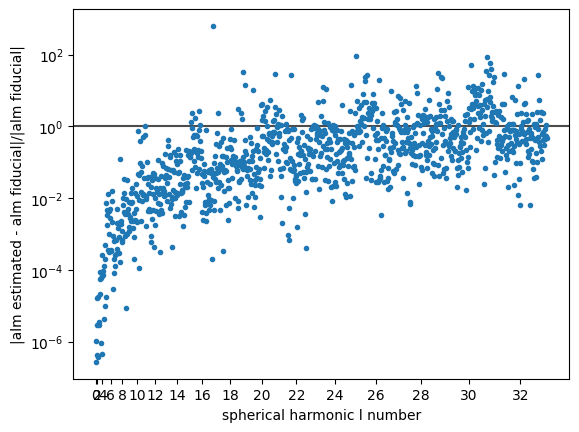

In [4]:
# Observe and reconstruct trivially:
mat_A_triv = FM.calc_observation_matrix_all_pix(nside, lmax, Ntau=npix, beam_use=narrow_cosbeam)

d_triv = mat_A_triv @ fg_alm
dnoisy_triv, noise_covar_triv = SM.add_noise(d_triv, 1, Ntau=npix, t_int=1e4)

mat_W_triv = MM.calc_ml_estimator_matrix(mat_A_triv, noise_covar_triv)
aml_triv = mat_W_triv @ dnoisy_triv

PL.compare_estimate_to_reality(fg_alm, aml_triv, ylm_mat, nside)

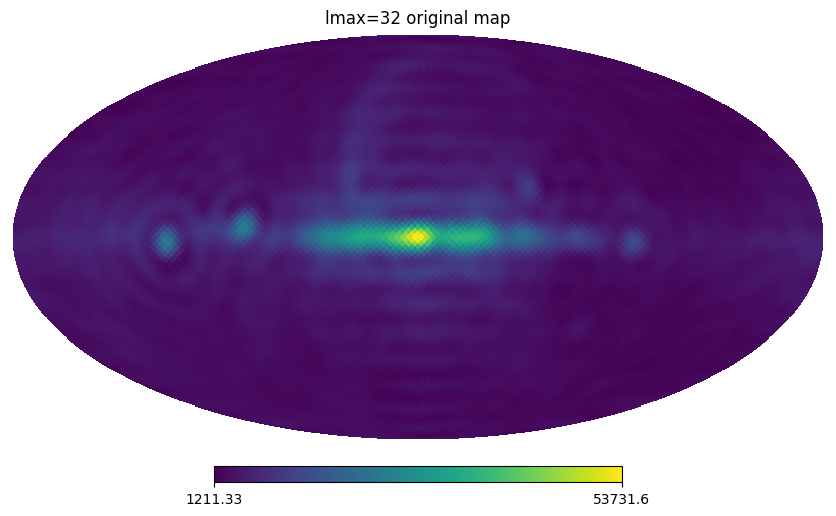

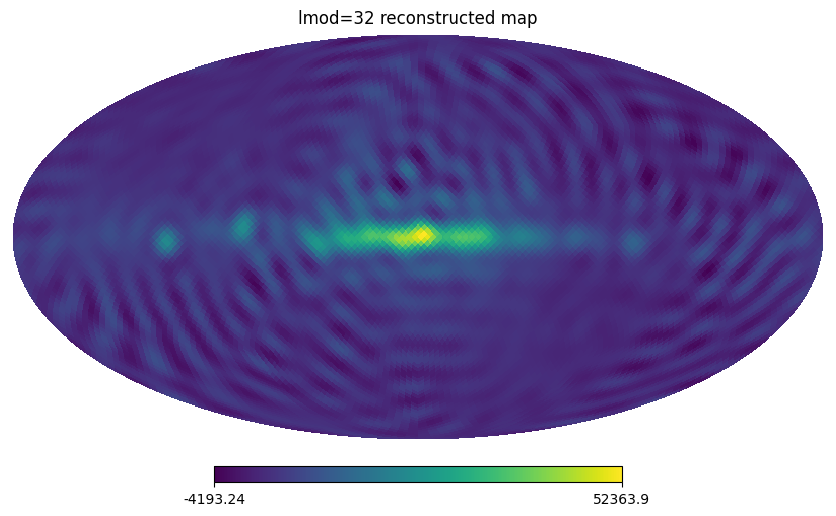

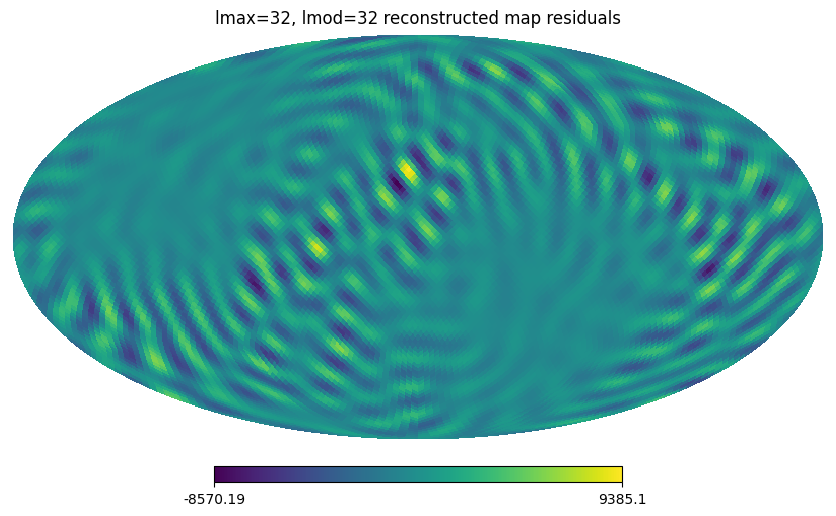

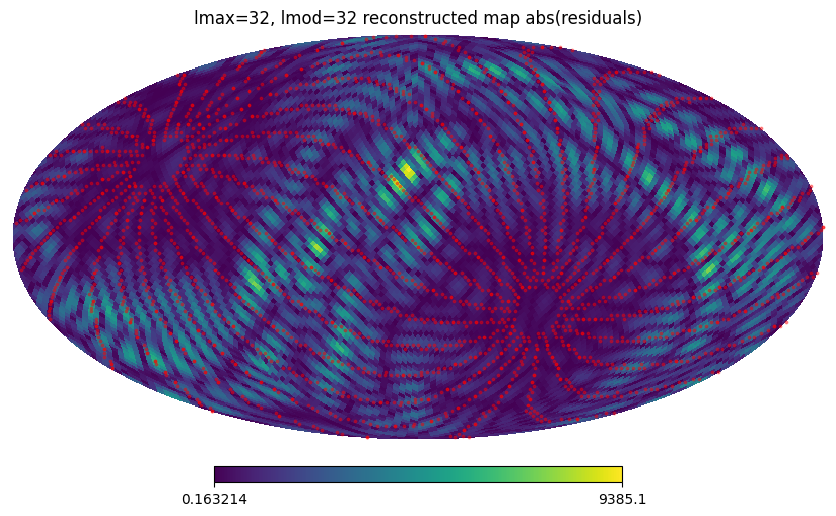

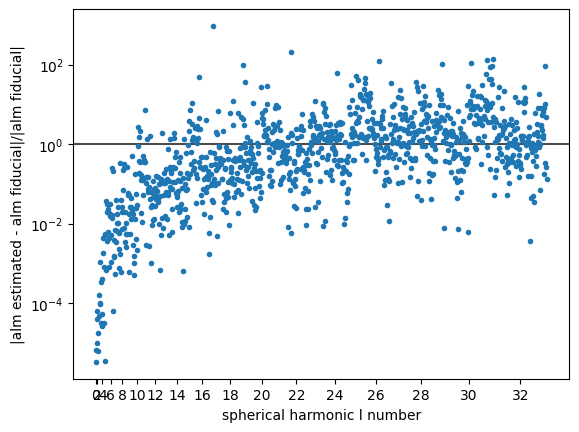

In [5]:
# Observe and reconstruct using a normal observation strategy:
lats = np.linspace(-80, 80, 100)
times = np.linspace(0, 24, 24, endpoint=False)
mat_A_norm, (_, mat_P_norm, _, _) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
mat_A_norm_lo = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax=lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)

d_norm = mat_A_norm @ fg_alm
dnoisy_norm, noise_covar_norm = SM.add_noise(d_norm, 1, Ntau=len(times), t_int=1e4)

mat_W_norm = MM.calc_ml_estimator_matrix(mat_A_norm_lo, noise_covar_norm)
aml_norm = mat_W_norm @ dnoisy_norm

PL.compare_estimate_to_reality(fg_alm, aml_norm, ylm_mat, nside, mat_P_norm)

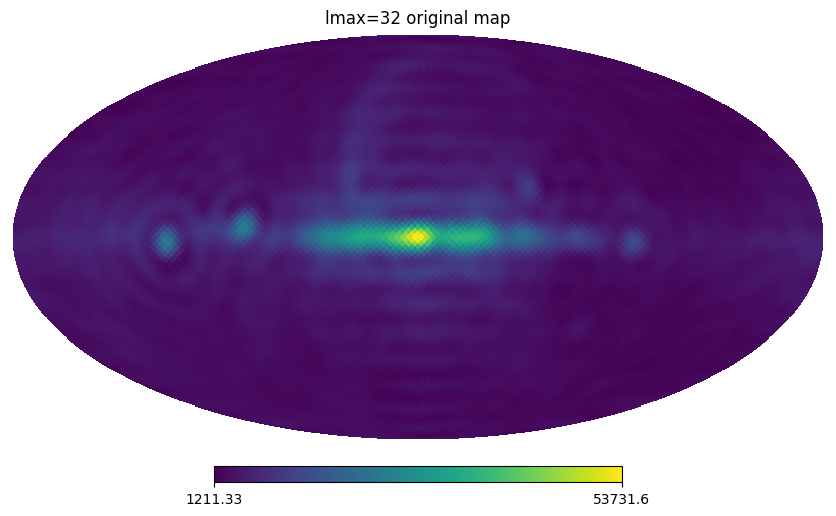

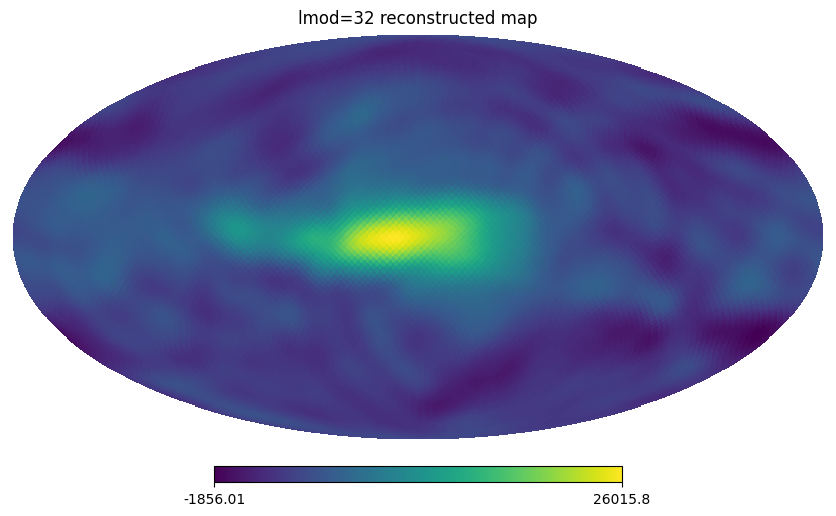

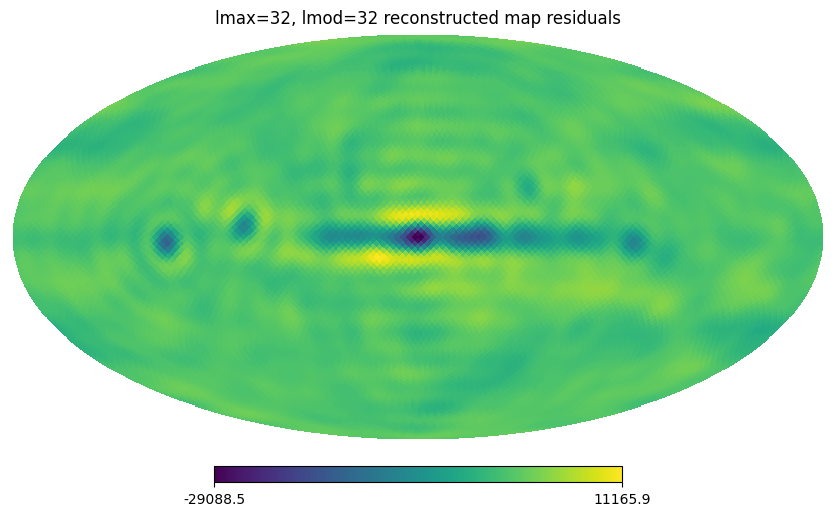

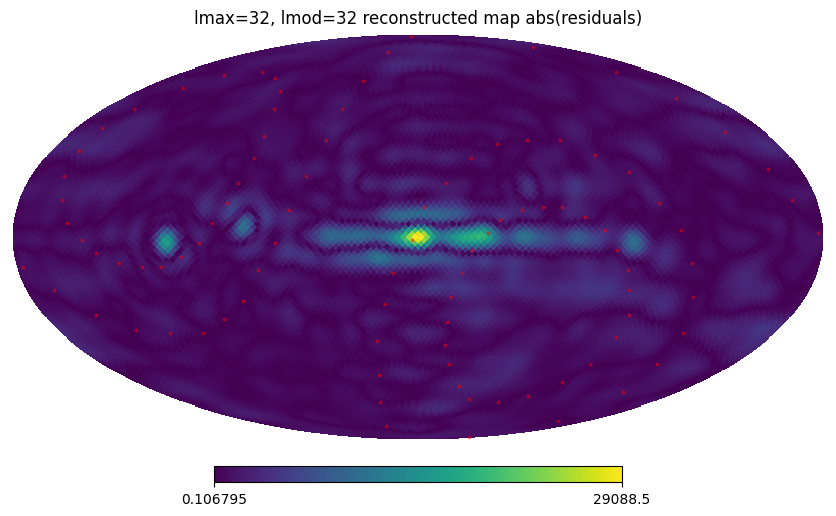

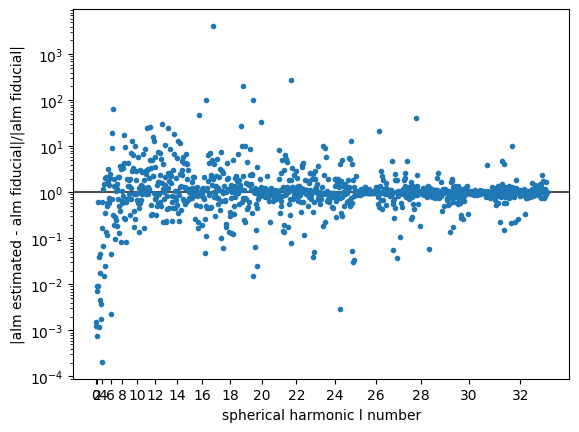

In [17]:
# Observe and reconstruct using a normal observation strategy and low lmod:
lmod = lmax
nside = 32
lats = np.array([-26*2, -26, 26, 26*2])
times = np.linspace(0, 24, 24, endpoint=False)
mat_A_norm, (_, mat_P_norm, mat_y, _) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
mat_A_norm_lo = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax=lmod, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)

d_norm = mat_A_norm @ fg_alm
dnoisy_norm, noise_covar_norm = SM.add_noise(d_norm, 1, Ntau=len(times), t_int=1e4)

mat_W_norm = MM.calc_ml_estimator_matrix(mat_A_norm_lo, noise_covar_norm, delta=1e-3)
aml_norm = mat_W_norm @ dnoisy_norm

PL.compare_estimate_to_reality(fg_alm, aml_norm, mat_y, nside, mat_P_norm)

## Multi-frequency reconstruction.
### Trivial observation without 21-cm signal

In [7]:
# model and observation params
lmax=32
nside=32
npix=hp.nside2npix(nside)
nuarr=np.linspace(50,100,51)
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)

npix = hp.nside2npix(nside)

# Generate foreground map.
fg_alm_bl = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


In [ ]:
# Observe and reconstruct trivially:
mat_A_triv = FM.calc_observation_matrix_all_pix(nside, lmax, Ntau=npix, beam_use=narrow_cosbeam)
mat_Abl_triv = BlockMatrix(mat=mat_A_triv, mode='block', nblock=len(nuarr))

d_triv_bl = mat_Abl_triv @ fg_alm_bl
dnoisy_triv_bl, noise_covar_triv_bl = SM.add_noise(d_triv_bl, 1, Ntau=npix, t_int=1e4)

mat_Wbl_triv = MM.calc_ml_estimator_matrix(mat_Abl_triv, noise_covar_triv_bl)
aml_triv_bl = mat_Wbl_triv @ dnoisy_triv_bl

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


In [ ]:
fg_alm_bl.shape, aml_triv_bl.vector.shape

In [ ]:
plt.semilogy(abs((fg_alm_bl-aml_triv_bl.vector)/fg_alm_bl))
fig = plt.gcf()
fig.set_size_inches(20,2)
plt.axhline(y=1, linestyle=':', color='k')
plt.ylabel('|alm estimated \n - alm fiducial \n / alm fiducial|')
plt.show()

### Trivial observation with 21-cm signal

In [44]:
# model and observation params
lmax=32
nside=16
Nalm=RS.get_size(lmax)
npix=hp.nside2npix(nside)
nuarr=np.linspace(50,100,51)
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)

npix = hp.nside2npix(nside)

# Generate foreground map.
fg_alm_bl = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True)

# Generate 21-cm signal alm.
params = (-0.2, 80.0, 5.0)
cm21_alm_bl = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=params)

successfully loaded spherical_harmonic_matrix npix, nalm : 3072 561


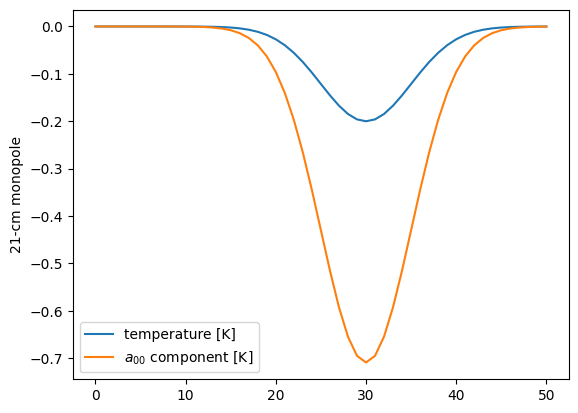

In [45]:
plt.plot(SM.cm21_dipoleT(nu=nuarr)[0], label="temperature [K]")
plt.plot(cm21_alm_bl[::Nalm], label="$a_{00}$ component [K]")
plt.ylabel("21-cm monopole")
plt.legend()
plt.show()

In [46]:
# Observe and reconstruct trivially:
mat_A_triv = FM.calc_observation_matrix_all_pix(nside, lmax, Ntau=npix, beam_use=narrow_cosbeam)
mat_Abl_triv = BlockMatrix(mat=mat_A_triv, mode='block', nblock=len(nuarr))

d_triv_bl = mat_Abl_triv @ (fg_alm_bl + cm21_alm_bl)
dnoisy_triv_bl, noise_covar_triv_bl = SM.add_noise(d_triv_bl, 1, Ntau=npix, t_int=1e4)

mat_Wbl_triv = MM.calc_ml_estimator_matrix(mat_Abl_triv, noise_covar_triv_bl)
aml_triv_bl = mat_Wbl_triv @ dnoisy_triv_bl

successfully loaded spherical_harmonic_matrix npix, nalm : 3072 561


In [47]:
# Fit the foreground and 21-cm monopole.
def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return fg_a00_terms

def cm21_mod(nuarr, *theta_21):
    A21, nu0, dnu = theta_21
    cm21_a00_terms = np.sqrt(4*np.pi) * A21 * np.exp(-.5*((nuarr-nu0)/dnu)**2)
    return cm21_a00_terms

def fg_cm21_polymod(nuarr, *theta):
    theta_fg = theta[:-3]
    theta_21 = theta[-3:]
    return fg_polymod(nuarr, *theta_fg) + cm21_mod(nuarr, *theta_21)

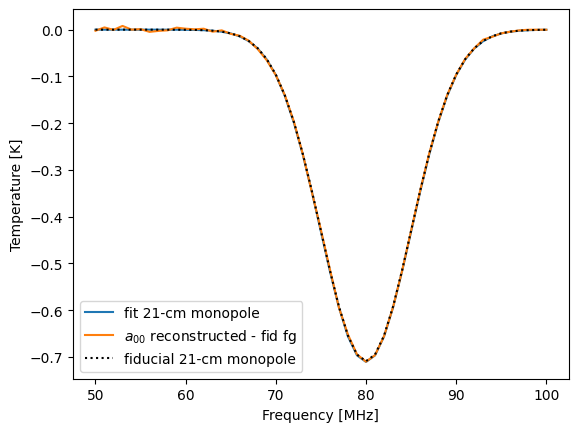

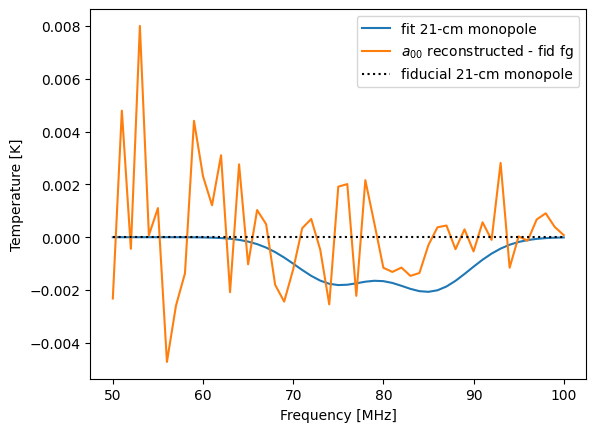

In [48]:
# Extract the monopole component of the reconstructed alm.
fg_a00 = np.array(fg_alm_bl[::Nalm])
reconstructed_a00 = np.array(aml_triv_bl.vector[::Nalm])

fg_mon_p0 = [15, 2.5, .001]
cm21_mon_p0 = [-0.2, 80, 5]
res = curve_fit(f=fg_cm21_polymod, xdata=nuarr, ydata=reconstructed_a00, p0=fg_mon_p0+cm21_mon_p0)

plt.plot(nuarr, cm21_mod(nuarr, *res[0][-3:]), label='fit 21-cm monopole')
plt.plot(nuarr, reconstructed_a00-fg_a00, label='$a_{00}$ reconstructed - fid fg')
plt.plot(nuarr, cm21_mod(nuarr, *cm21_mon_p0), label='fiducial 21-cm monopole', linestyle=':', color='k')
plt.legend()
plt.ylabel("Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.show()

plt.plot(nuarr, cm21_mod(nuarr, *res[0][-3:])-cm21_mod(nuarr, *cm21_mon_p0), label='fit 21-cm monopole')
plt.plot(nuarr, reconstructed_a00-fg_a00-cm21_mod(nuarr, *cm21_mon_p0), label='$a_{00}$ reconstructed - fid fg')
plt.plot(nuarr, cm21_mod(nuarr, *cm21_mon_p0)-cm21_mod(nuarr, *cm21_mon_p0), label='fiducial 21-cm monopole', linestyle=':', color='k')
plt.legend()
plt.ylabel("Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.show()

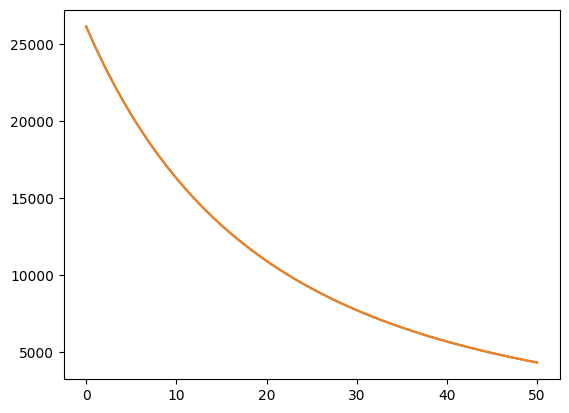

In [7]:
plt.plot(aml_triv_bl.vector[::Nalm])
plt.plot(fg_cm21_polymod(nuarr, *res[0]))

In [ ]:
# Observe and reconstruct trivially:
mat_A_triv = FM.calc_observation_matrix_all_pix(nside, lmax, Ntau=npix, beam_use=narrow_cosbeam)
mat_Abl_triv = BlockMatrix(mat=mat_A_triv, mode='block', nblock=len(nuarr))

d_triv_bl = mat_Abl_triv @ (fg_alm_bl + cm21_alm_bl)
dnoisy_triv_bl, noise_covar_triv_bl = SM.add_noise(d_triv_bl, 1, Ntau=npix, t_int=1e4)

mat_Wbl_triv = MM.calc_ml_estimator_matrix(mat_Abl_triv, noise_covar_triv_bl)
aml_triv_bl = mat_Wbl_triv @ dnoisy_triv_bl

In [40]:
# Observe and reconstruct using a normal observation strategy:
nside=16
lmax=32
lmod=3
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)
lats = np.array([-26*2, -26, 26, 26*2])#np.linspace(-80, 80, 100)
times = np.linspace(0, 24, 24, endpoint=False)
nuarr=np.linspace(50,100,51)

# Set up observation matrix for mock data.
mat_A_norm = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam)
mat_Abl_norm = BlockMatrix(mat=mat_A_norm, mode='block', nblock=len(nuarr))

# Set up observation matrix for model.
mat_A_norm_lo = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax=lmod, lats=lats, times=times, beam_use=narrow_cosbeam)
mat_Abl_norm_lo = BlockMatrix(mat=mat_A_norm_lo, mode='block', nblock=len(nuarr))

# Observe data.
d_norm_bl = mat_Abl_norm @ (fg_alm_bl + cm21_alm_bl)
dnoisy_norm_bl, noise_covar_norm_bl = SM.add_noise(d_norm_bl, 1, Ntau=len(times), t_int=1e4)

mat_Wbl_norm = MM.calc_ml_estimator_matrix(mat_Abl_norm_lo, noise_covar_norm_bl)
aml_norm_bl = mat_Wbl_norm @ dnoisy_norm_bl

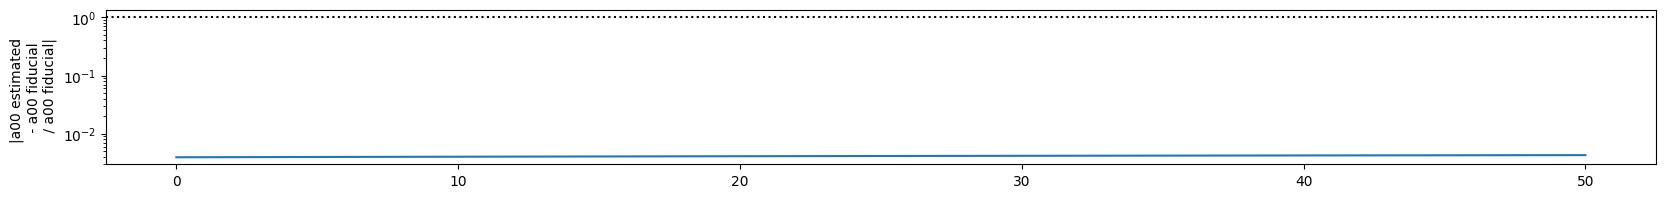

In [41]:
# Extract fiducial and reconstructed a00 modes.
fid_alm = np.array(fg_alm_bl + cm21_alm_bl)
fid_a00 = np.array(fid_alm[::Nlmax])
rec_a00 = np.array(aml_norm_bl.vector[::Nlmod])

plt.semilogy(abs((fid_a00-rec_a00)/fid_a00))
fig = plt.gcf()
fig.set_size_inches(20,2)
plt.axhline(y=1, linestyle=':', color='k')
plt.ylabel('|a00 estimated \n - a00 fiducial \n / a00 fiducial|')
plt.show()

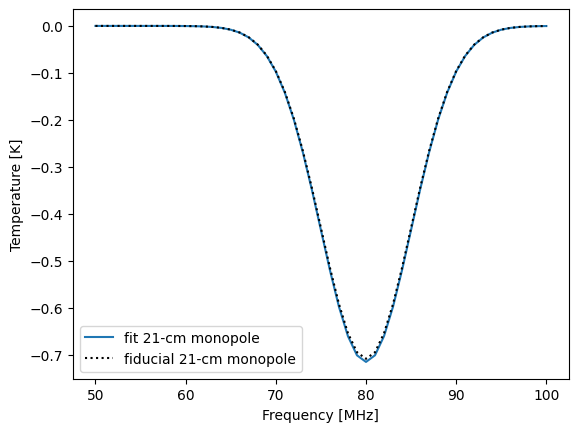

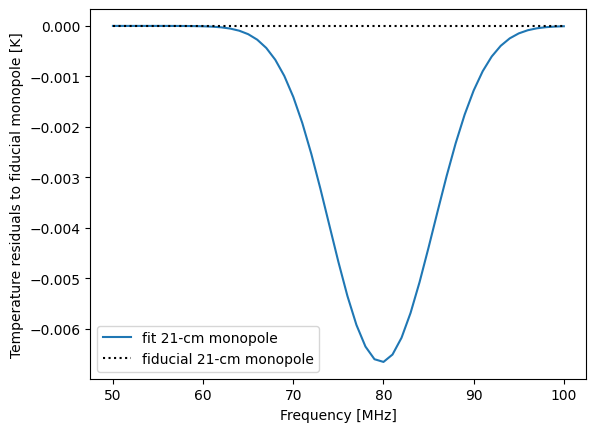

In [42]:
fg_mon_p0 = [15, 2.5, .001]
cm21_mon_p0 = [-0.2, 80, 5]
res = curve_fit(f=fg_cm21_polymod, xdata=nuarr, ydata=rec_a00, p0=fg_mon_p0+cm21_mon_p0)

fidfg_a00 = np.array(fg_alm_bl[::Nlmax])

plt.plot(nuarr, cm21_mod(nuarr, *res[0][-3:]), label='fit 21-cm monopole')
#plt.plot(nuarr, rec_a00-fidfg_a00, label='$a_{00}$ reconstructed - fid fg')
plt.plot(nuarr, cm21_mod(nuarr, *cm21_mon_p0), label='fiducial 21-cm monopole', linestyle=':', color='k')
plt.legend()
plt.ylabel("Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.show()

plt.plot(nuarr, cm21_mod(nuarr, *res[0][-3:])-cm21_mod(nuarr, *cm21_mon_p0), label='fit 21-cm monopole')
#plt.plot(nuarr, rec_a00-fidfg_a00-cm21_mod(nuarr, *cm21_mon_p0), label='$a_{00}$ reconstructed - fid fg')
plt.plot(nuarr, cm21_mod(nuarr, *cm21_mon_p0)-cm21_mod(nuarr, *cm21_mon_p0), label='fiducial 21-cm monopole', linestyle=':', color='k')
plt.legend()
plt.ylabel("Temperature residuals to fiducial monopole [K]")
plt.xlabel("Frequency [MHz]")
plt.show()

In [57]:
rec_alm=np.load("rec_alm.npy", allow_pickle=True)
fid_alm=np.load("fid_alm.npy", allow_pickle=True)

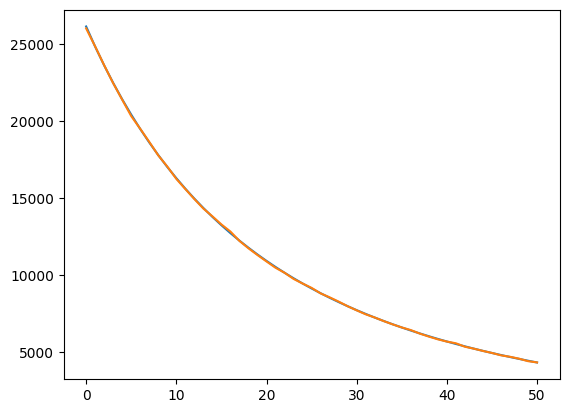

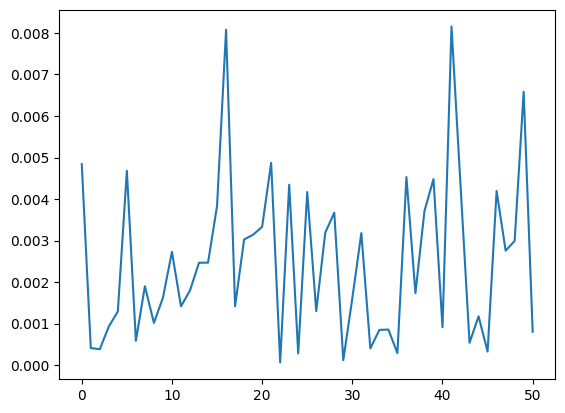

In [66]:
rec_a00 = rec_alm[::RS.get_size(32)]
fid_a00 = fid_alm[::RS.get_size(32)]
plt.plot(fid_a00)
plt.plot(rec_a00)
plt.show()
plt.plot(np.abs((fid_a00-rec_a00)/fid_a00))
plt.show()